In [2]:
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.mixture import GaussianMixture

from sklearn.metrics import f1_score
import scipy.stats as sps

Данные представляем в виде различных 2 коспонент PCA (зотим визуализировать результат).
Сравниваем на полученных данных различные алгоритмы кластеризации.  
    1) DBSCAN  
    2) Иерархическая кластеризация  
    3) Гауссовские смеси (EM-алгоритм)  

In [3]:
def nbinom_params(m, s):
    p = m / (s*s)
    n = int(m*m / (s*s - m)) + 1
    return p, n

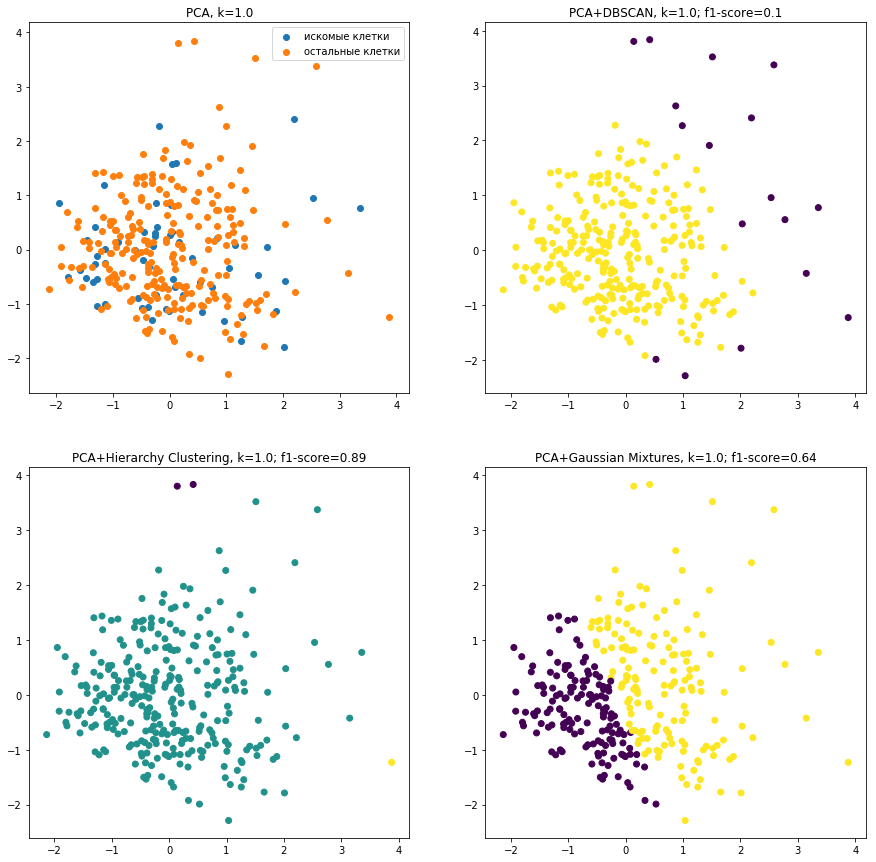

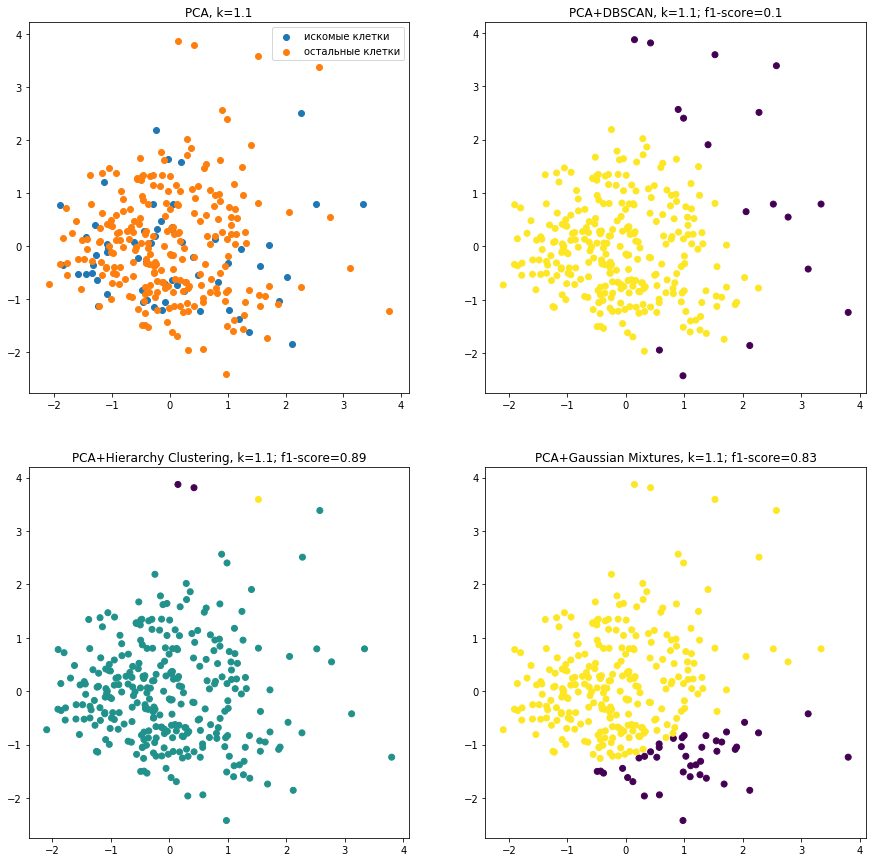

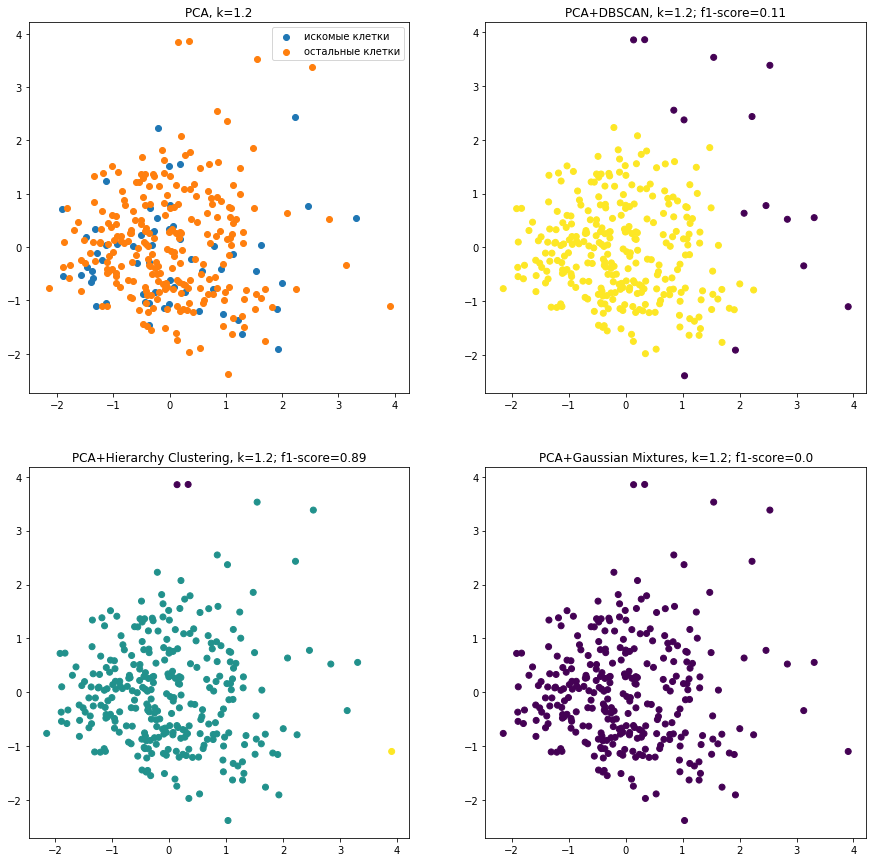

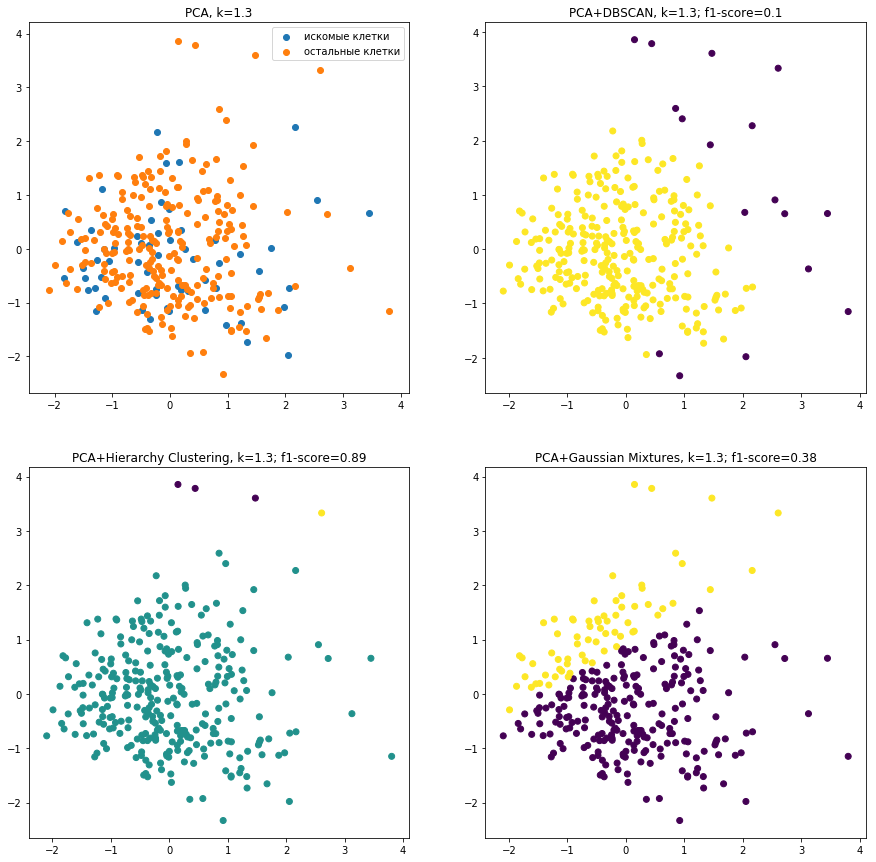

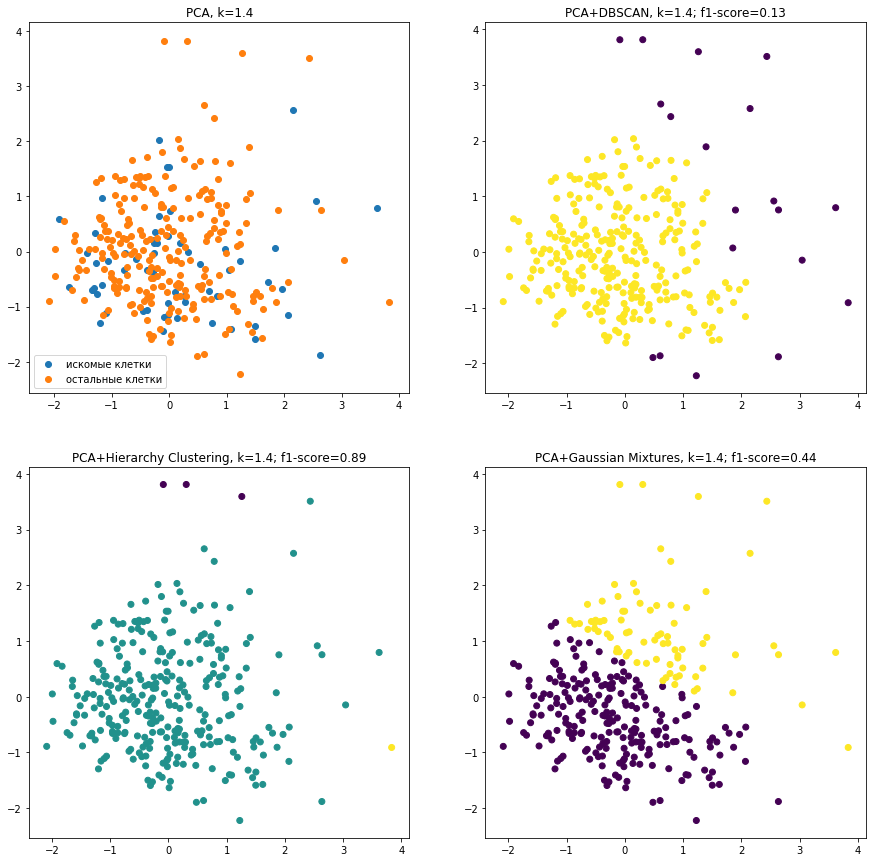

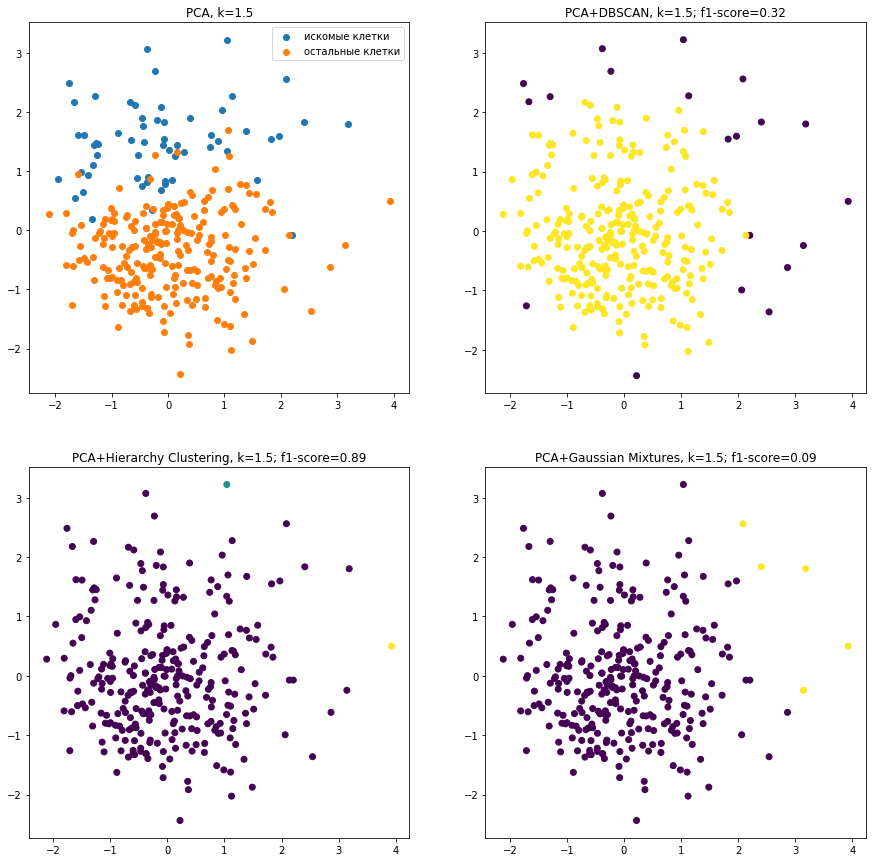

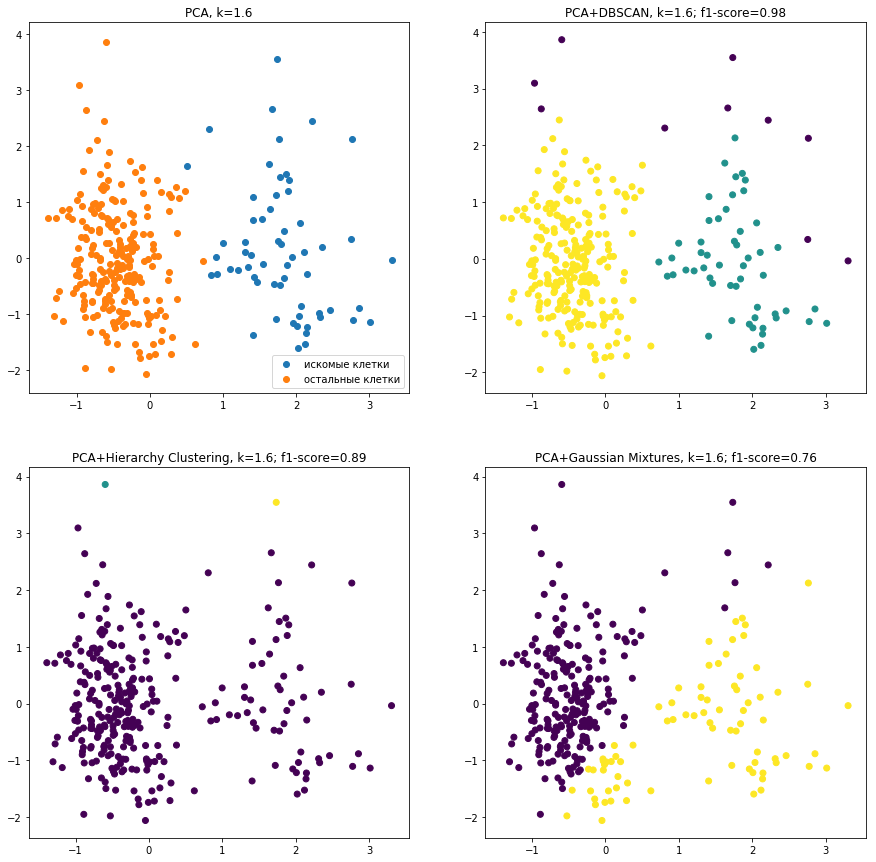

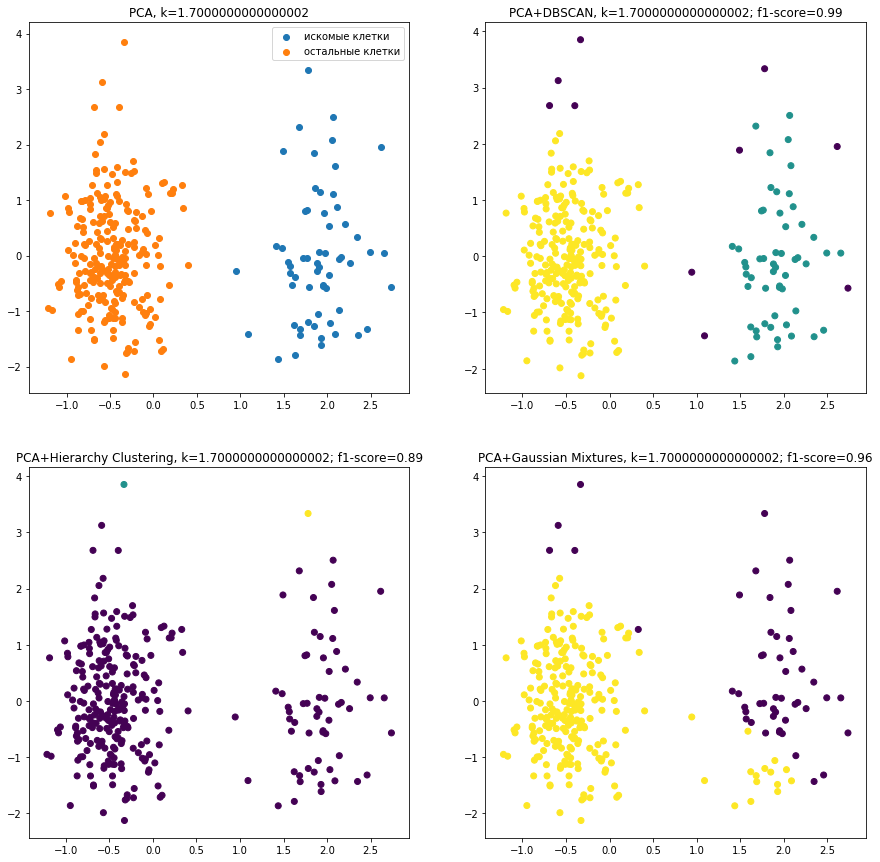

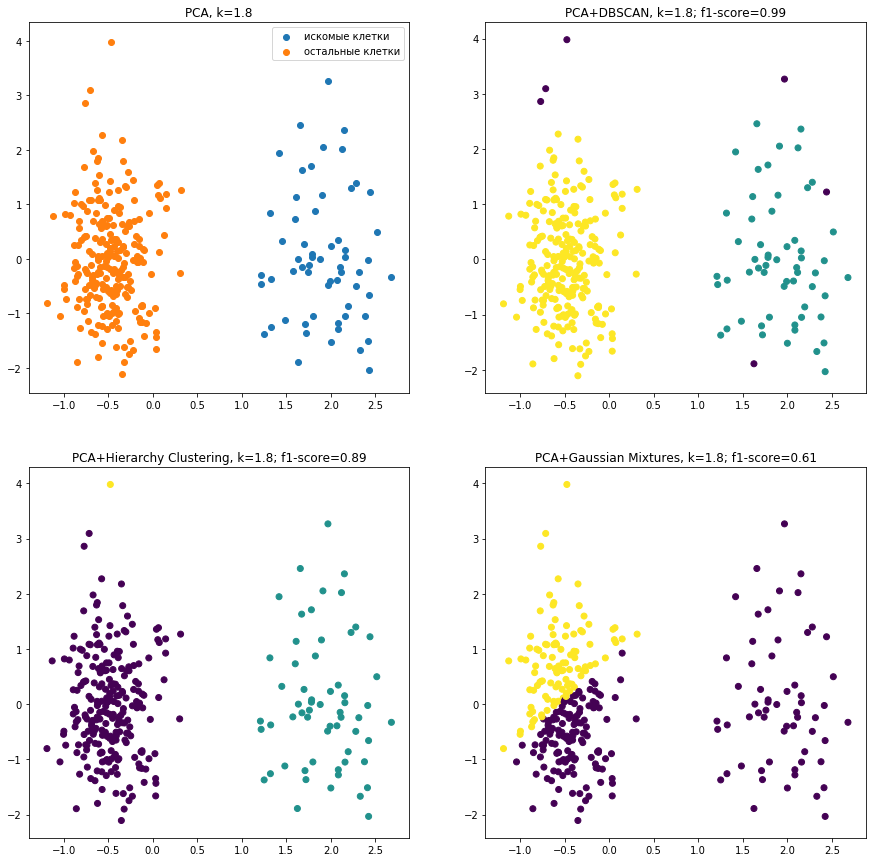

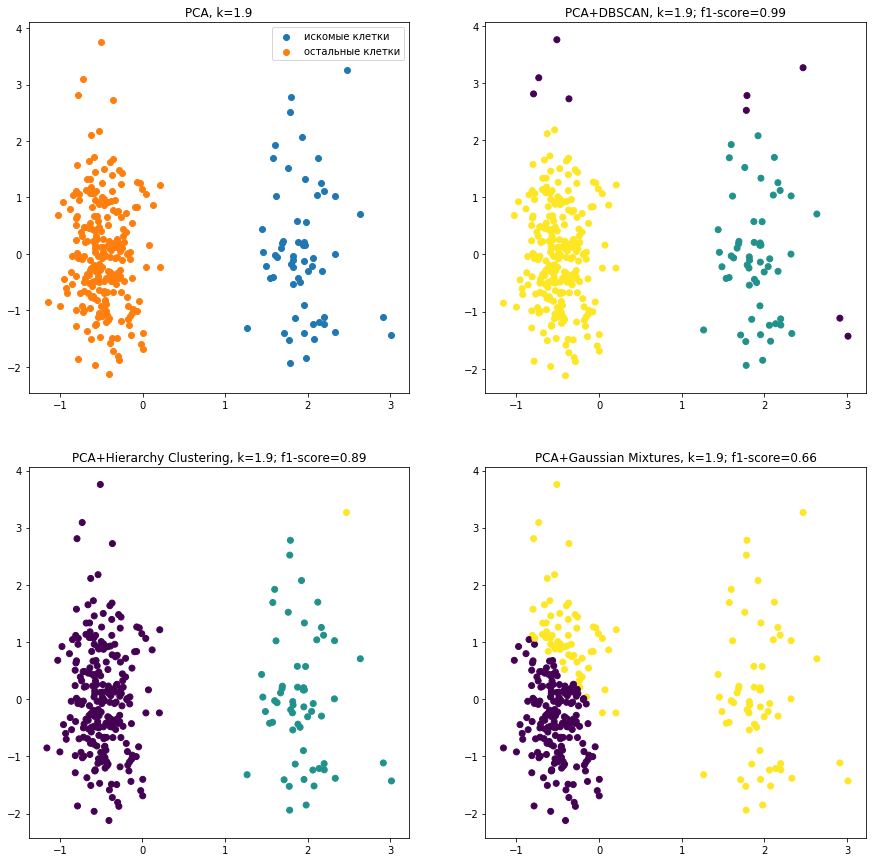

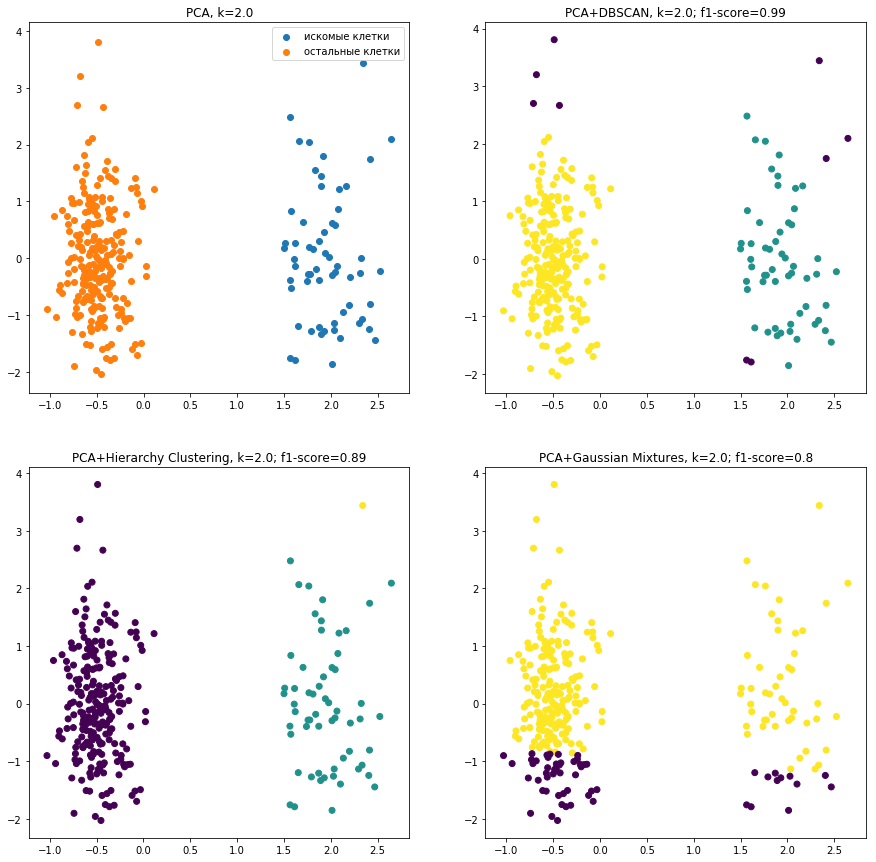

In [4]:
# количество клеток
N = 300
# количество генов
G = 1000
# ожидаемая доля искомых клеток
a = 0.2
# количество известных маркеров для искомой клетки
p = 10
# количество всех маркеров для искомой клетки
P = 20

M = sps.uniform.rvs(loc=0, scale=1000, size=N)
S = sps.uniform.rvs(loc=np.ceil(np.sqrt(M)), scale=M/2, size=len(M))

expressions = np.zeros((G, N))
# все гены
for gene, m, s in zip(range(G), M, S):
    p, n = nbinom_params(m, s)
    expressions[gene] = sps.nbinom.rvs(n=n, p=p, size=N)
    
# маркерные гены
for k in np.linspace(1, 2, 11):
    N_spec = int(N*a)
    for gene, m, s in zip(range(P), M, S):
        m = m * k
        s = s * np.sqrt(k)
        p, n = nbinom_params(m, s)
        expressions[gene][:N_spec] = sps.nbinom.rvs(n=n, p=p, size=N_spec)

    X = expressions.T    

    n_components = 2
    
    y = np.zeros(N)
    y[:N_spec] = 1
    
    pca = PCA(n_components=n_components)
    sc = StandardScaler()
    X_pca = sc.fit_transform(pca.fit_transform(X))
    
    db = DBSCAN(eps=0.5)
    y_pred_db = db.fit_predict(X_pca)
    
    mergings = linkage(X_pca)
    y_pred_hc = fcluster(mergings, t=3, criterion='maxclust')
    
    gm = GaussianMixture(n_components=2, init_params='random', 
                          n_init=300, covariance_type='tied')
    y_pred_gm = gm.fit_predict(X_pca)
       
    plt.figure(figsize=(15, 15))
    
    plt.subplot(221)
    plt.scatter(X_pca.T[0][:N_spec], X_pca.T[1][:N_spec], label='искомые клетки')
    plt.scatter(X_pca.T[0][N_spec:], X_pca.T[1][N_spec:], label='остальные клетки')
    plt.legend()
    plt.title('PCA, k={}'.format(k))
    
    plt.subplot(222)
    plt.scatter(X_pca.T[0], X_pca.T[1], c=y_pred_db)
    f1_db = np.max([f1_score(y_pred_db != 0, y), f1_score(y_pred_db != 0, 1-y)])
    plt.title('PCA+DBSCAN, k={}; f1-score={}'.format(k, np.round(f1_db, 2)))
    
    plt.subplot(223)
    plt.scatter(X_pca.T[0], X_pca.T[1], c=y_pred_hc)
    f1_hc = np.max([f1_score(y_pred_hc != 0, y), f1_score(y_pred_hc != 0, 1-y)])
    plt.title('PCA+Hierarchy Clustering, k={}; f1-score={}'.format(k, np.round(f1_hc, 2)))
    
    plt.subplot(224)
    plt.scatter(X_pca.T[0], X_pca.T[1], c=y_pred_gm)
    f1_gm = np.max([f1_score(y_pred_gm != 0, y), f1_score(y_pred_gm != 0, 1-y)])
    plt.title('PCA+Gaussian Mixtures, k={}; f1-score={}'.format(k, np.round(f1_gm, 2)))
    plt.show()